In [1]:
import torchvision
import torch
from torchvision import models
from torchvision import transforms
from torchvision import utils
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import itertools
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch import nn
import datetime
import matplotlib.pyplot as plt

In [2]:
img_size = 28
n_batches = 64
learning_rate = 0.0002
transform = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])


C:\Users\april\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [3]:
%matplotlib inline
fmnist = torchvision.datasets.FashionMNIST(root="./", train=True,
transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=fmnist,
batch_size=64, shuffle=True)

In [4]:
# Critic
#https://github.com/mickypaganini/GAN_tutorial/blob/master/GANtutorial_PyTorch_FashionMNIST.ipynb
# Note that we just have a linear output here
critic = nn.Sequential(
    nn.Linear(28 * 28, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

# Generator 
generator = nn.Sequential(
    nn.Linear(64, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 28 * 28),
    nn.Tanh()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()

In [5]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [6]:
from torchvision.utils import save_image

def denorm(x):
    # convert back from [-1, 1] to [0, 1]
    out = (x + 1) / 2
    return out #out.clamp(0, 1)

In [7]:
# These are the recommended defaults (sauf N_EPOCHS) from the WGAN paper.
LR = 0.00005
N_EPOCHS = 100
N_CRITIC_STEPS = 5
CLAMP = 0.01 #c ***

## c from the set {0.1, 0.01, 0.001, 0.0001} and compare the difference from the MSE loss.

In [ ]:
CLAMP = 0.1

In [ ]:
CLAMP = 0.001

In [ ]:
CLAMP = 0.0001

In [8]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

### For the training loop, we want to alternate between N_CRITIC_STEPS critic updates and a single generator update. We'll keep a counter that will help us know where we are.

In [9]:
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        D_losses = []
        G_losses = []
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                D_losses.append(critic_loss)
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                G_losses.append(generator_loss)
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print(datetime.datetime.now(),'Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            #critic_loss.data[0],
                            critic_loss.data.item(),
                            #generator_loss.data[0],
                            generator_loss.data.item(),
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/wgan_real_images.png')

        # Save sampled images
        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
       # torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        #torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

2020-04-27 12:52:43.279648 Epoch [0/100], Step[300/64], d_loss: -0.5530, g_loss: -4.0767, Mean D(x): 4.65, Mean D(G(z)): 4.10
2020-04-27 12:52:47.881169 Epoch [0/100], Step[600/64], d_loss: -0.2755, g_loss: -3.7707, Mean D(x): 4.03, Mean D(G(z)): 3.75
2020-04-27 12:52:52.478185 Epoch [0/100], Step[900/64], d_loss: -0.1015, g_loss: -2.3369, Mean D(x): 2.44, Mean D(G(z)): 2.34
2020-04-27 12:52:57.595729 Epoch [1/100], Step[300/64], d_loss: -1.3566, g_loss: -0.1460, Mean D(x): 1.47, Mean D(G(z)): 0.11
2020-04-27 12:53:02.100844 Epoch [1/100], Step[600/64], d_loss: -2.7818, g_loss: -1.3921, Mean D(x): 4.18, Mean D(G(z)): 1.40
2020-04-27 12:53:06.646332 Epoch [1/100], Step[900/64], d_loss: -3.2949, g_loss: -0.7369, Mean D(x): 4.04, Mean D(G(z)): 0.75
2020-04-27 12:53:11.761431 Epoch [2/100], Step[300/64], d_loss: -2.8031, g_loss: -0.9557, Mean D(x): 3.76, Mean D(G(z)): 0.95
2020-04-27 12:53:16.332529 Epoch [2/100], Step[600/64], d_loss: -2.7317, g_loss: -1.1822, Mean D(x): 3.76, Mean D(G(z)

2020-04-27 12:57:53.690537 Epoch [21/100], Step[900/64], d_loss: -1.5006, g_loss: -0.9044, Mean D(x): 2.42, Mean D(G(z)): 0.92
2020-04-27 12:57:58.872563 Epoch [22/100], Step[300/64], d_loss: -1.5371, g_loss: -0.3369, Mean D(x): 2.04, Mean D(G(z)): 0.51
2020-04-27 12:58:03.396676 Epoch [22/100], Step[600/64], d_loss: -1.3622, g_loss: -0.6728, Mean D(x): 2.04, Mean D(G(z)): 0.68
2020-04-27 12:58:07.963601 Epoch [22/100], Step[900/64], d_loss: -1.3713, g_loss: -0.3296, Mean D(x): 1.60, Mean D(G(z)): 0.23
2020-04-27 12:58:13.181443 Epoch [23/100], Step[300/64], d_loss: -1.6246, g_loss: -0.6609, Mean D(x): 2.33, Mean D(G(z)): 0.71
2020-04-27 12:58:17.741761 Epoch [23/100], Step[600/64], d_loss: -1.5196, g_loss: -0.7168, Mean D(x): 2.26, Mean D(G(z)): 0.74
2020-04-27 12:58:22.311466 Epoch [23/100], Step[900/64], d_loss: -1.1904, g_loss: -0.7954, Mean D(x): 1.90, Mean D(G(z)): 0.71
2020-04-27 12:58:27.577998 Epoch [24/100], Step[300/64], d_loss: -1.4450, g_loss: -0.7793, Mean D(x): 2.26, Mea

2020-04-27 13:03:04.139782 Epoch [43/100], Step[600/64], d_loss: -0.8834, g_loss: -1.0546, Mean D(x): 1.97, Mean D(G(z)): 1.08
2020-04-27 13:03:08.674915 Epoch [43/100], Step[900/64], d_loss: -0.9133, g_loss: -0.9418, Mean D(x): 1.92, Mean D(G(z)): 1.01
2020-04-27 13:03:13.861007 Epoch [44/100], Step[300/64], d_loss: -0.9676, g_loss: -0.9306, Mean D(x): 1.96, Mean D(G(z)): 1.00
2020-04-27 13:03:18.423789 Epoch [44/100], Step[600/64], d_loss: -0.9218, g_loss: -0.9270, Mean D(x): 1.90, Mean D(G(z)): 0.98
2020-04-27 13:03:22.984100 Epoch [44/100], Step[900/64], d_loss: -1.0226, g_loss: -0.9461, Mean D(x): 1.97, Mean D(G(z)): 0.95
2020-04-27 13:03:28.170602 Epoch [45/100], Step[300/64], d_loss: -0.8700, g_loss: -1.0735, Mean D(x): 2.03, Mean D(G(z)): 1.16
2020-04-27 13:03:32.745674 Epoch [45/100], Step[600/64], d_loss: -0.8372, g_loss: -1.0053, Mean D(x): 1.88, Mean D(G(z)): 1.04
2020-04-27 13:03:37.270091 Epoch [45/100], Step[900/64], d_loss: -0.9041, g_loss: -1.1837, Mean D(x): 2.01, Mea

2020-04-27 13:08:14.052592 Epoch [65/100], Step[300/64], d_loss: -0.6960, g_loss: -1.0721, Mean D(x): 1.76, Mean D(G(z)): 1.07
2020-04-27 13:08:18.619168 Epoch [65/100], Step[600/64], d_loss: -0.7703, g_loss: -1.0728, Mean D(x): 1.82, Mean D(G(z)): 1.05
2020-04-27 13:08:23.155125 Epoch [65/100], Step[900/64], d_loss: -0.7405, g_loss: -1.0644, Mean D(x): 1.70, Mean D(G(z)): 0.96
2020-04-27 13:08:28.384873 Epoch [66/100], Step[300/64], d_loss: -0.6273, g_loss: -0.9900, Mean D(x): 1.51, Mean D(G(z)): 0.89
2020-04-27 13:08:32.961221 Epoch [66/100], Step[600/64], d_loss: -0.6925, g_loss: -0.9226, Mean D(x): 1.71, Mean D(G(z)): 1.01
2020-04-27 13:08:37.519226 Epoch [66/100], Step[900/64], d_loss: -0.6173, g_loss: -1.0139, Mean D(x): 1.61, Mean D(G(z)): 0.99
2020-04-27 13:08:42.634790 Epoch [67/100], Step[300/64], d_loss: -0.7090, g_loss: -0.9679, Mean D(x): 1.73, Mean D(G(z)): 1.03
2020-04-27 13:08:47.170538 Epoch [67/100], Step[600/64], d_loss: -0.6430, g_loss: -1.2640, Mean D(x): 1.78, Mea

2020-04-27 13:13:23.600255 Epoch [86/100], Step[900/64], d_loss: -0.4878, g_loss: -1.0341, Mean D(x): 1.56, Mean D(G(z)): 1.07
2020-04-27 13:13:28.767851 Epoch [87/100], Step[300/64], d_loss: -0.4507, g_loss: -0.9786, Mean D(x): 1.50, Mean D(G(z)): 1.05
2020-04-27 13:13:33.295757 Epoch [87/100], Step[600/64], d_loss: -0.5222, g_loss: -0.8691, Mean D(x): 1.33, Mean D(G(z)): 0.81
2020-04-27 13:13:37.870152 Epoch [87/100], Step[900/64], d_loss: -0.4717, g_loss: -0.8408, Mean D(x): 1.38, Mean D(G(z)): 0.90
2020-04-27 13:13:43.023572 Epoch [88/100], Step[300/64], d_loss: -0.5081, g_loss: -0.8798, Mean D(x): 1.42, Mean D(G(z)): 0.91
2020-04-27 13:13:47.544923 Epoch [88/100], Step[600/64], d_loss: -0.4974, g_loss: -0.9576, Mean D(x): 1.41, Mean D(G(z)): 0.91
2020-04-27 13:13:52.088782 Epoch [88/100], Step[900/64], d_loss: -0.4635, g_loss: -0.9592, Mean D(x): 1.37, Mean D(G(z)): 0.91
2020-04-27 13:13:57.273111 Epoch [89/100], Step[300/64], d_loss: -0.4101, g_loss: -0.7049, Mean D(x): 1.27, Mea

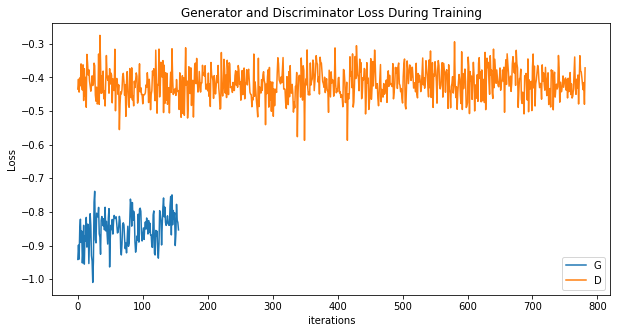

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [21]:
NB_SAMPLES = 50
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

In [22]:
NB_SAMPLES = 50
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final.png', nrow=10)
import IPython
IPython.display.Image('./data/wgan_fake_images_final.png')

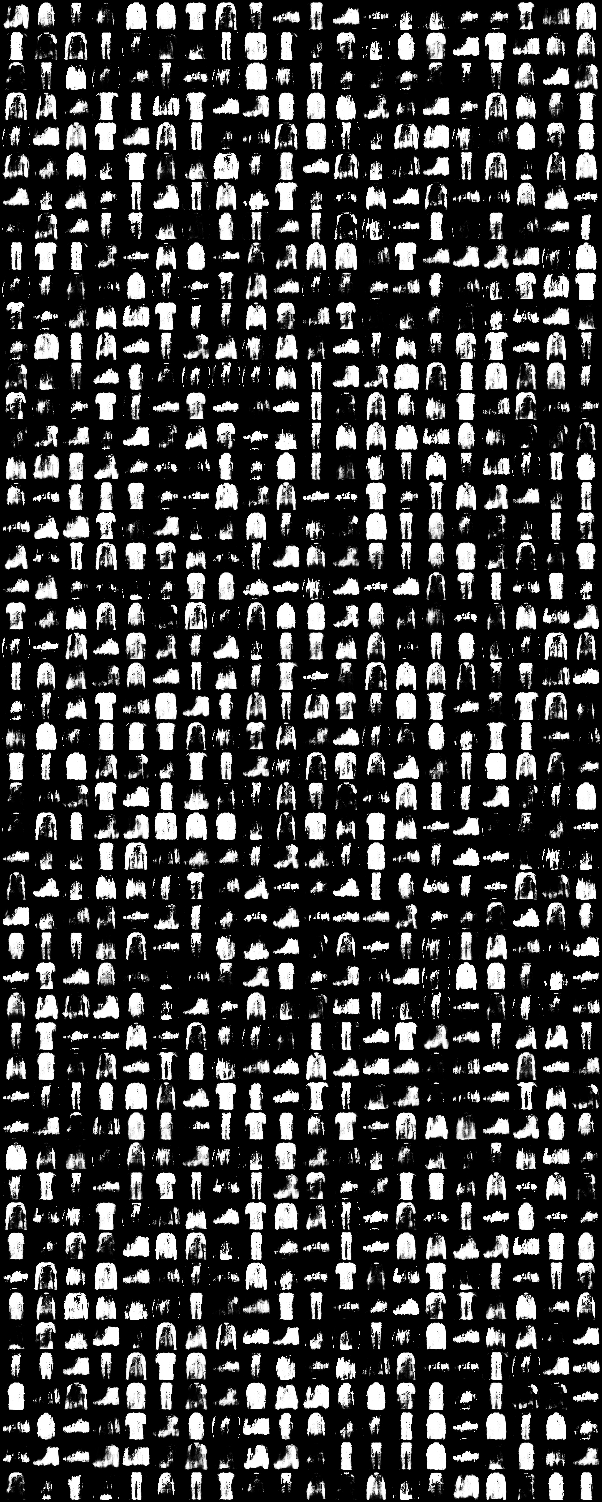

In [23]:
import IPython
IPython.display.Image('./data/wgan_fake_images_final.png')

# CLAMP = 0.1

In [24]:
CLAMP = 0.1

In [28]:
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        D_losses = []
        G_losses = []
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                D_losses.append(critic_loss)
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                G_losses.append(generator_loss)
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print(datetime.datetime.now(),'Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            #critic_loss.data[0],
                            critic_loss.data.item(),
                            #generator_loss.data[0],
                            generator_loss.data.item(),
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/wgan_real_images.png')

        # Save sampled images
        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
       # torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        #torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

2020-05-01 19:40:42.677215 Epoch [0/100], Step[300/64], d_loss: -143.1807, g_loss: -772.3320, Mean D(x): 877.13, Mean D(G(z)): 733.95
2020-05-01 19:40:47.271469 Epoch [0/100], Step[600/64], d_loss: -225.4619, g_loss: -573.5988, Mean D(x): 789.61, Mean D(G(z)): 564.15
2020-05-01 19:40:51.919719 Epoch [0/100], Step[900/64], d_loss: -250.9039, g_loss: -623.2981, Mean D(x): 840.73, Mean D(G(z)): 589.83
2020-05-01 19:40:57.169977 Epoch [1/100], Step[300/64], d_loss: -197.3846, g_loss: -418.4747, Mean D(x): 642.93, Mean D(G(z)): 445.55
2020-05-01 19:41:01.790548 Epoch [1/100], Step[600/64], d_loss: -211.0663, g_loss: -809.4412, Mean D(x): 1016.23, Mean D(G(z)): 805.16
2020-05-01 19:41:06.481202 Epoch [1/100], Step[900/64], d_loss: -167.0035, g_loss: -770.3264, Mean D(x): 962.30, Mean D(G(z)): 795.30
2020-05-01 19:41:11.738381 Epoch [2/100], Step[300/64], d_loss: -116.3857, g_loss: -803.3621, Mean D(x): 866.87, Mean D(G(z)): 750.49
2020-05-01 19:41:16.369608 Epoch [2/100], Step[600/64], d_los

2020-05-01 19:45:37.442309 Epoch [20/100], Step[600/64], d_loss: -105.3211, g_loss: -856.5114, Mean D(x): 993.10, Mean D(G(z)): 887.78
2020-05-01 19:45:42.084986 Epoch [20/100], Step[900/64], d_loss: -159.9484, g_loss: -975.3248, Mean D(x): 1143.33, Mean D(G(z)): 983.38
2020-05-01 19:45:47.363144 Epoch [21/100], Step[300/64], d_loss: -103.9989, g_loss: -896.5740, Mean D(x): 1010.58, Mean D(G(z)): 906.58
2020-05-01 19:45:51.941616 Epoch [21/100], Step[600/64], d_loss: -37.5581, g_loss: -1005.1749, Mean D(x): 1050.35, Mean D(G(z)): 1012.79
2020-05-01 19:45:56.562049 Epoch [21/100], Step[900/64], d_loss: -66.5952, g_loss: -923.1036, Mean D(x): 1014.07, Mean D(G(z)): 947.48
2020-05-01 19:46:01.848664 Epoch [22/100], Step[300/64], d_loss: -75.2604, g_loss: -1015.7877, Mean D(x): 1077.10, Mean D(G(z)): 1001.84
2020-05-01 19:46:06.461561 Epoch [22/100], Step[600/64], d_loss: -109.4502, g_loss: -1004.7316, Mean D(x): 1108.73, Mean D(G(z)): 999.28
2020-05-01 19:46:11.107518 Epoch [22/100], Step

2020-05-01 19:50:26.235789 Epoch [40/100], Step[600/64], d_loss: -103.7068, g_loss: -1051.7600, Mean D(x): 1137.56, Mean D(G(z)): 1033.85
2020-05-01 19:50:30.785361 Epoch [40/100], Step[900/64], d_loss: -117.7874, g_loss: -1131.0784, Mean D(x): 1235.85, Mean D(G(z)): 1118.06
2020-05-01 19:50:35.974978 Epoch [41/100], Step[300/64], d_loss: -76.8232, g_loss: -1055.1434, Mean D(x): 1126.49, Mean D(G(z)): 1049.66
2020-05-01 19:50:40.522446 Epoch [41/100], Step[600/64], d_loss: -111.6747, g_loss: -1057.5490, Mean D(x): 1159.67, Mean D(G(z)): 1047.99
2020-05-01 19:50:45.074068 Epoch [41/100], Step[900/64], d_loss: -71.3016, g_loss: -1003.9904, Mean D(x): 1092.81, Mean D(G(z)): 1021.51
2020-05-01 19:50:50.261681 Epoch [42/100], Step[300/64], d_loss: -106.0012, g_loss: -1009.1255, Mean D(x): 1149.88, Mean D(G(z)): 1043.88
2020-05-01 19:50:54.807823 Epoch [42/100], Step[600/64], d_loss: -98.8455, g_loss: -1077.4952, Mean D(x): 1216.19, Mean D(G(z)): 1117.34
2020-05-01 19:50:59.358916 Epoch [42/

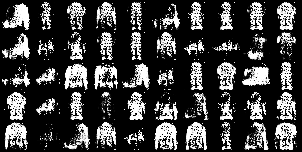

In [29]:
NB_SAMPLES = 50
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final1.png', nrow=10)
import IPython
IPython.display.Image('./data/wgan_fake_images_final1.png')

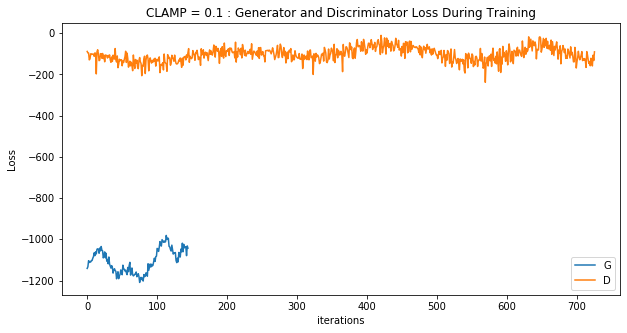

In [30]:
NB_SAMPLES = 50
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final.png', nrow=10)
import IPython
IPython.display.Image('./data/wgan_fake_images_final.png')
plt.figure(figsize=(10,5))
plt.title("CLAMP = 0.1 : Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# CLAMP = 0.001

In [31]:
CLAMP = 0.001
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        D_losses = []
        G_losses = []
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                D_losses.append(critic_loss)
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                G_losses.append(generator_loss)
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print(datetime.datetime.now(),'Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            #critic_loss.data[0],
                            critic_loss.data.item(),
                            #generator_loss.data[0],
                            generator_loss.data.item(),
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/wgan_real_images.png')

        # Save sampled images
        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
       # torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        #torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

2020-05-01 19:52:48.684018 Epoch [0/100], Step[300/64], d_loss: -0.0001, g_loss: -0.0010, Mean D(x): 0.00, Mean D(G(z)): 0.00
2020-05-01 19:52:53.303913 Epoch [0/100], Step[600/64], d_loss: -0.0002, g_loss: -0.0009, Mean D(x): 0.00, Mean D(G(z)): 0.00
2020-05-01 19:52:57.910517 Epoch [0/100], Step[900/64], d_loss: -0.0003, g_loss: -0.0006, Mean D(x): 0.00, Mean D(G(z)): 0.00
2020-05-01 19:53:03.126424 Epoch [1/100], Step[300/64], d_loss: -0.0010, g_loss: -0.0000, Mean D(x): 0.00, Mean D(G(z)): -0.00
2020-05-01 19:53:07.753669 Epoch [1/100], Step[600/64], d_loss: -0.0031, g_loss: 0.0010, Mean D(x): 0.00, Mean D(G(z)): -0.00
2020-05-01 19:53:12.397026 Epoch [1/100], Step[900/64], d_loss: -0.0083, g_loss: 0.0046, Mean D(x): 0.00, Mean D(G(z)): -0.00
2020-05-01 19:53:17.715216 Epoch [2/100], Step[300/64], d_loss: -0.0100, g_loss: 0.0046, Mean D(x): 0.01, Mean D(G(z)): -0.00
2020-05-01 19:53:22.407630 Epoch [2/100], Step[600/64], d_loss: -0.0107, g_loss: 0.0046, Mean D(x): 0.01, Mean D(G(z)

2020-05-01 19:58:01.701040 Epoch [21/100], Step[900/64], d_loss: -0.0008, g_loss: 0.0038, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:07.204352 Epoch [22/100], Step[300/64], d_loss: -0.0013, g_loss: 0.0043, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:12.063388 Epoch [22/100], Step[600/64], d_loss: -0.0012, g_loss: 0.0027, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:16.923071 Epoch [22/100], Step[900/64], d_loss: -0.0012, g_loss: 0.0016, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:22.458594 Epoch [23/100], Step[300/64], d_loss: -0.0009, g_loss: 0.0043, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:27.280725 Epoch [23/100], Step[600/64], d_loss: -0.0009, g_loss: 0.0035, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:32.114666 Epoch [23/100], Step[900/64], d_loss: -0.0009, g_loss: 0.0048, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 19:58:37.616580 Epoch [24/100], Step[300/64], d_loss: -0.0010, g_loss: 0.0063, Mean D(x): -0.

2020-05-01 20:03:29.670376 Epoch [43/100], Step[600/64], d_loss: -0.0005, g_loss: 0.0032, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:03:34.435142 Epoch [43/100], Step[900/64], d_loss: -0.0007, g_loss: 0.0048, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:03:39.879021 Epoch [44/100], Step[300/64], d_loss: -0.0004, g_loss: 0.0037, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:03:44.662819 Epoch [44/100], Step[600/64], d_loss: -0.0006, g_loss: 0.0015, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:03:49.480740 Epoch [44/100], Step[900/64], d_loss: -0.0005, g_loss: 0.0025, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:03:54.905361 Epoch [45/100], Step[300/64], d_loss: -0.0006, g_loss: 0.0027, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:03:59.735422 Epoch [45/100], Step[600/64], d_loss: -0.0011, g_loss: 0.0052, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:04:04.522995 Epoch [45/100], Step[900/64], d_loss: -0.0004, g_loss: 0.0030, Mean D(x): -0.

2020-05-01 20:08:54.675126 Epoch [65/100], Step[300/64], d_loss: -0.0001, g_loss: 0.0018, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:08:59.315625 Epoch [65/100], Step[600/64], d_loss: -0.0005, g_loss: -0.0006, Mean D(x): 0.00, Mean D(G(z)): -0.00
2020-05-01 20:09:03.914074 Epoch [65/100], Step[900/64], d_loss: -0.0003, g_loss: 0.0012, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:09:09.205604 Epoch [66/100], Step[300/64], d_loss: -0.0003, g_loss: 0.0014, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:09:13.823986 Epoch [66/100], Step[600/64], d_loss: -0.0003, g_loss: 0.0015, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:09:18.410682 Epoch [66/100], Step[900/64], d_loss: 0.0001, g_loss: 0.0015, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:09:23.675038 Epoch [67/100], Step[300/64], d_loss: -0.0005, g_loss: 0.0026, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:09:28.270346 Epoch [67/100], Step[600/64], d_loss: -0.0004, g_loss: 0.0020, Mean D(x): -0.0

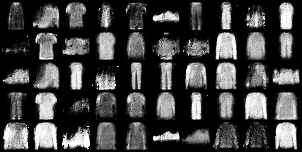

In [35]:
NB_SAMPLES = 50
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final001.png', nrow=10)
import IPython
IPython.display.Image('./data/wgan_fake_images_final001.png')


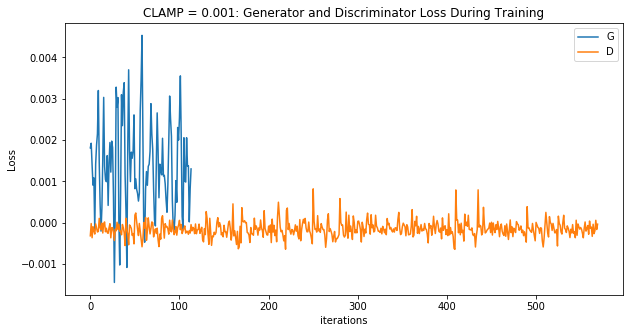

In [36]:
plt.figure(figsize=(10,5))
plt.title("CLAMP = 0.001: Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# CLAMP = 0.0001

In [37]:
CLAMP = 0.0001
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        D_losses = []
        G_losses = []
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                D_losses.append(critic_loss)
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                G_losses.append(generator_loss)
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print(datetime.datetime.now(),'Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            #critic_loss.data[0],
                            critic_loss.data.item(),
                            #generator_loss.data[0],
                            generator_loss.data.item(),
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/wgan_real_images.png')

        # Save sampled images
        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
       # torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        #torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

2020-05-01 20:10:26.433904 Epoch [0/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:30.999703 Epoch [0/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:35.552874 Epoch [0/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:40.769045 Epoch [1/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:45.338477 Epoch [1/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:49.861314 Epoch [1/100], Step[900/64], d_loss: 0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:55.030830 Epoch [2/100], Step[300/64], d_loss: 0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:10:59.591913 Epoch [2/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D

2020-05-01 20:15:40.005920 Epoch [21/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:15:45.522326 Epoch [22/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:15:50.352005 Epoch [22/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:15:55.157526 Epoch [22/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:16:00.634214 Epoch [23/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:16:05.476546 Epoch [23/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:16:10.276194 Epoch [23/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0002, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:16:15.772293 Epoch [24/100], Step[300/64], d_loss: 0.0000, g_loss: 0.0001, Mean D(x): -0.0

2020-05-01 20:20:56.385905 Epoch [43/100], Step[600/64], d_loss: 0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:00.948897 Epoch [43/100], Step[900/64], d_loss: 0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:06.151953 Epoch [44/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:10.704894 Epoch [44/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:15.253228 Epoch [44/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:20.412162 Epoch [45/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:24.969744 Epoch [45/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:21:29.516963 Epoch [45/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00

2020-05-01 20:26:10.583546 Epoch [65/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:15.384408 Epoch [65/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:20.205325 Epoch [65/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:25.685716 Epoch [66/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:30.505740 Epoch [66/100], Step[600/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:35.331827 Epoch [66/100], Step[900/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:40.795541 Epoch [67/100], Step[300/64], d_loss: -0.0000, g_loss: 0.0001, Mean D(x): -0.00, Mean D(G(z)): -0.00
2020-05-01 20:26:45.545515 Epoch [67/100], Step[600/64], d_loss: 0.0000, g_loss: 0.0001, Mean D(x): -0.0

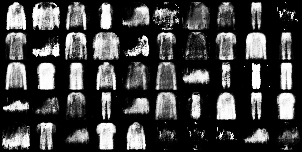

In [38]:
NB_SAMPLES = 50
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final0001.png', nrow=10)
import IPython
IPython.display.Image('./data/wgan_fake_images_final0001.png')


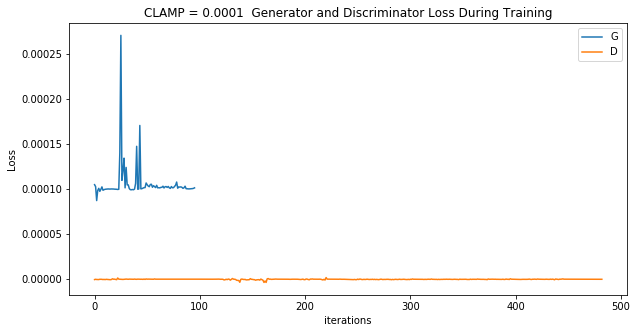

In [39]:
plt.figure(figsize=(10,5))
plt.title("CLAMP = 0.0001  Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()